In [1]:
import torch

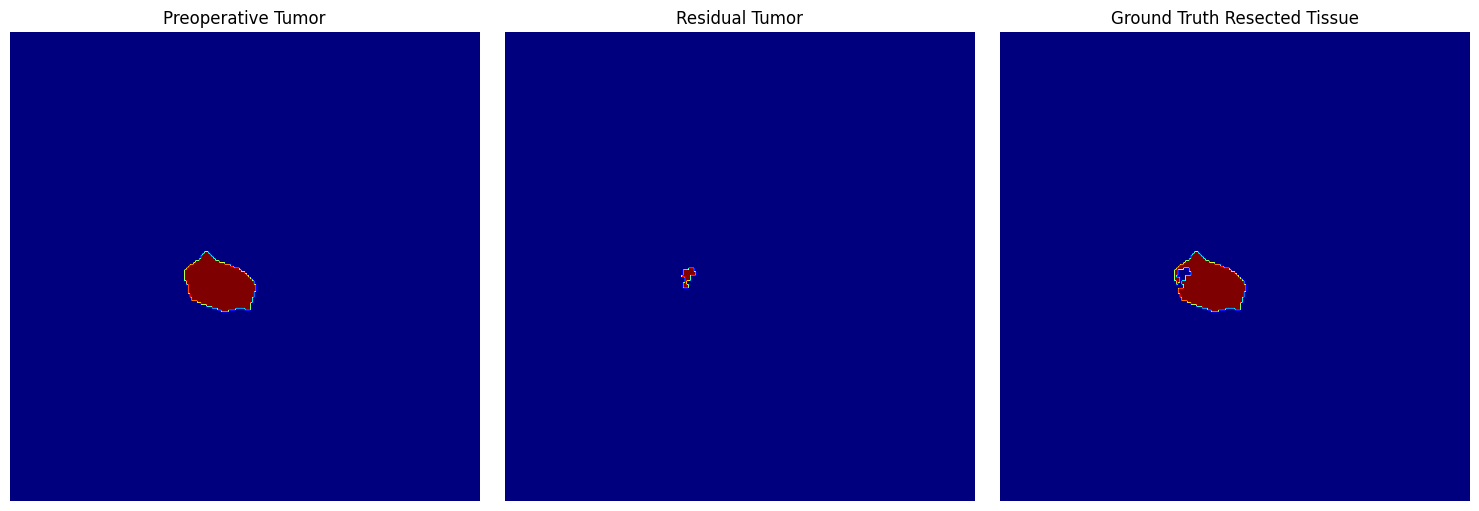

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Load the post-tumor label file
post_tumor_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/2D/ReMIND-039_slice_axial_140_post_tumor_label_0.npz'
post_tumor_data = np.rot90(np.load(post_tumor_file)['data'])
# post_tumor_data = np.ma.masked_where(post_tumor_data == 0, post_tumor_data)

# Load the pre-tumor file
pre_tumor_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/2D/ReMIND-039_slice_axial_140_pre_tumor_label_0.npz'
pre_tumor_data = np.rot90(np.load(pre_tumor_file)['data'])
# pre_tumor_data = np.ma.masked_where(pre_tumor_data == 0, pre_tumor_data)
# Load the change map file
change_map_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/2D/ReMIND-039_slice_axial_140_change_map_label_0.npz'
change_map_data = np.rot90(np.load(change_map_file)['data'])

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(pre_tumor_data, cmap='jet')
axes[0].set_title('Preoperative Tumor')

axes[1].imshow(post_tumor_data, cmap='jet')
axes[1].set_title('Residual Tumor')

axes[2].imshow(change_map_data, cmap='jet')
axes[2].set_title('Ground Truth Resected Tissue')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Mask the preoperative tumor data
masked_pre_tumor_data = np.ma.masked_where(pre_tumor_data == 0, pre_tumor_data)

# Mask the postoperative tumor data
masked_post_tumor_data = np.ma.masked_where(post_tumor_data == 0, post_tumor_data)

# Mask the change map data
masked_change_map_data = np.ma.masked_where(change_map_data == 0, change_map_data)


0.5321461306795863
0.0


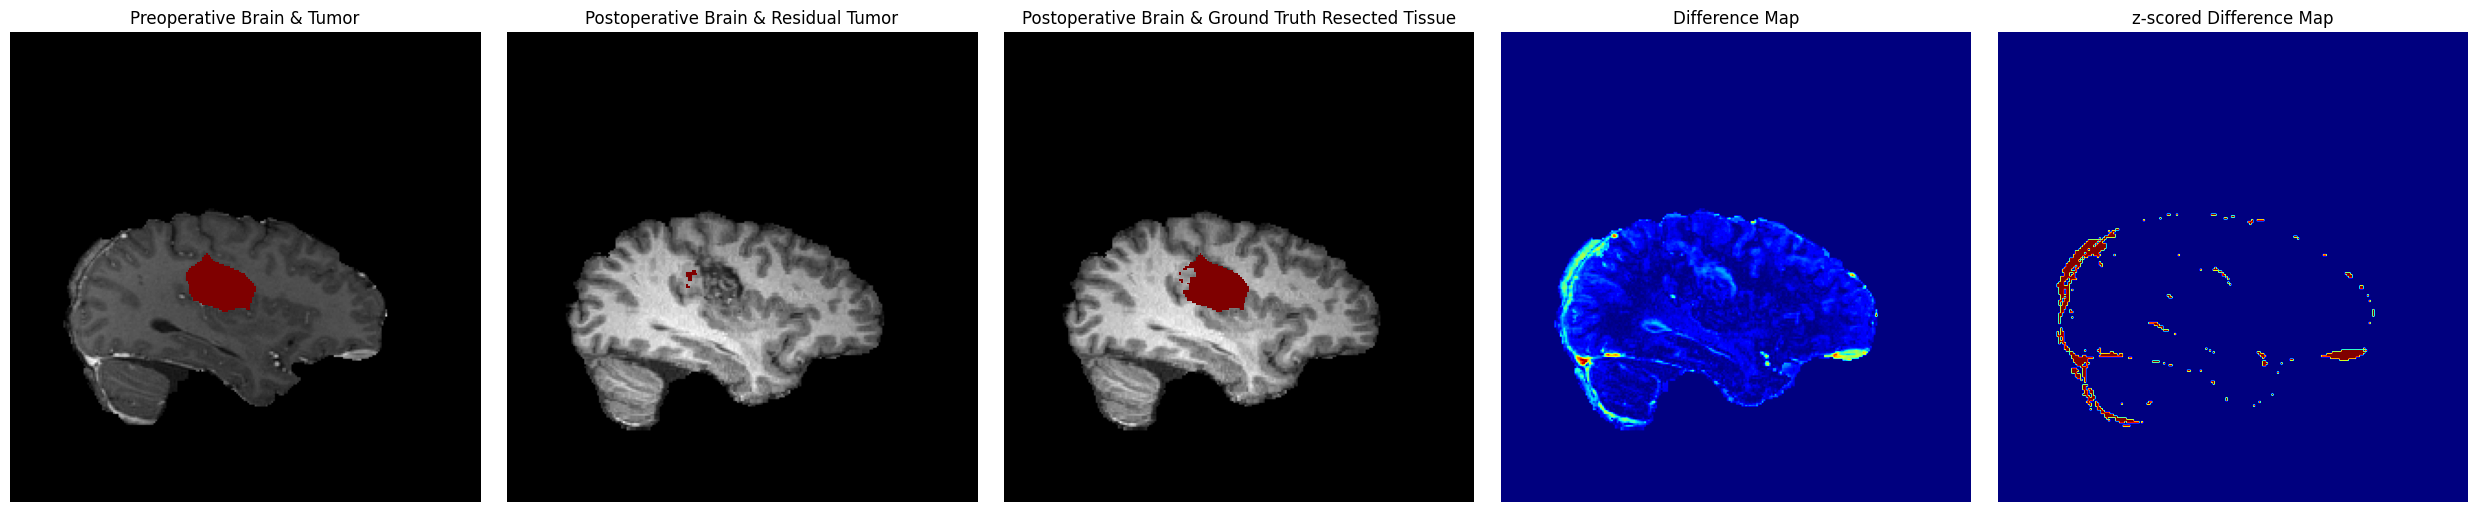

In [14]:
# Load the preoperative MRI scan file
preop_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_label_0.npz'
preop_data = np.rot90(np.load(preop_file)['data'])

# Load the postoperative MRI scan file
postop_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_label_0.npz'
postop_data = np.rot90(np.load(postop_file)['data'])
def get_baseline_np(pre: np.ndarray, post: np.ndarray) -> np.ndarray:
    diff = np.abs(pre - post)
    return diff

def threshold_by_zscore(diff_map, threshold=4):
    """Thresholds a difference map using Z-score significance."""
    mean_val = np.mean(diff_map)
    std_val = np.std(diff_map)

    # Compute Z-score
    z_scores = (diff_map - mean_val) / std_val

    # Keep only values beyond the threshold
    significant_map = np.abs(z_scores) > threshold

    return significant_map.astype(np.uint8)  # Convert to binary mask

baseline = get_baseline_np(preop_data, postop_data)
print(baseline.max())
print(baseline.min())
z_scored_baseline = threshold_by_zscore(baseline, threshold=4)
# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes[0].imshow(preop_data, cmap='gray')
axes[0].imshow(masked_pre_tumor_data, cmap='jet', alpha=1, vmin=0.1, vmax=1)
axes[0].set_title('Preoperative Brain & Tumor')

axes[1].imshow(postop_data, cmap='gray')
axes[1].imshow(masked_post_tumor_data, cmap='jet', alpha=1, vmin=0.5, vmax=1)
axes[1].set_title('Postoperative Brain & Residual Tumor')

axes[2].imshow(postop_data, cmap='gray')
axes[2].imshow(masked_change_map_data, cmap='jet', alpha=1, vmin=0.5, vmax=1)
axes[2].set_title('Postoperative Brain & Ground Truth Resected Tissue')

axes[3].imshow(baseline, cmap='jet')
axes[3].set_title('Difference Map')

axes[4].imshow(z_scored_baseline, cmap='jet')
axes[4].set_title('z-scored Difference Map')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:

from numpy import ndarray
import cv2
def normalize_np_array(array: ndarray) -> ndarray:
    if np.max(array) == np.min(array):
        return array
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def multiplicative_sharpening_and_filter(distance_map: np.ndarray, base_image: np.ndarray, alpha=2.0, beta=1, threshold=0.55):
    """Process the distance map with sharpening, without blending with the base image."""
    
    assert distance_map.max() <= 1.0, f"max: {distance_map.max()}"
    assert distance_map.min() >= 0.0, f"min: {distance_map.min()}"
    assert base_image.max() <= 1.0, f"max: {base_image.max()}"
    assert base_image.min() >= 0.0, f"min: {base_image.min()}"

    # Threshold and normalize the distance map
    distance_map = (distance_map > threshold).astype(np.float32) * distance_map

    # Extract high-frequency details from the base image
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)
    high_freq_details = base_image - blurred_image

    # Apply sharpening based purely on the distance map's strength
    sharpened_map = distance_map * (1 + alpha * high_freq_details)

    # Normalize the final enhanced distance map
    norm_enhanced_map = normalize_np_array(sharpened_map)

    return sharpened_map  

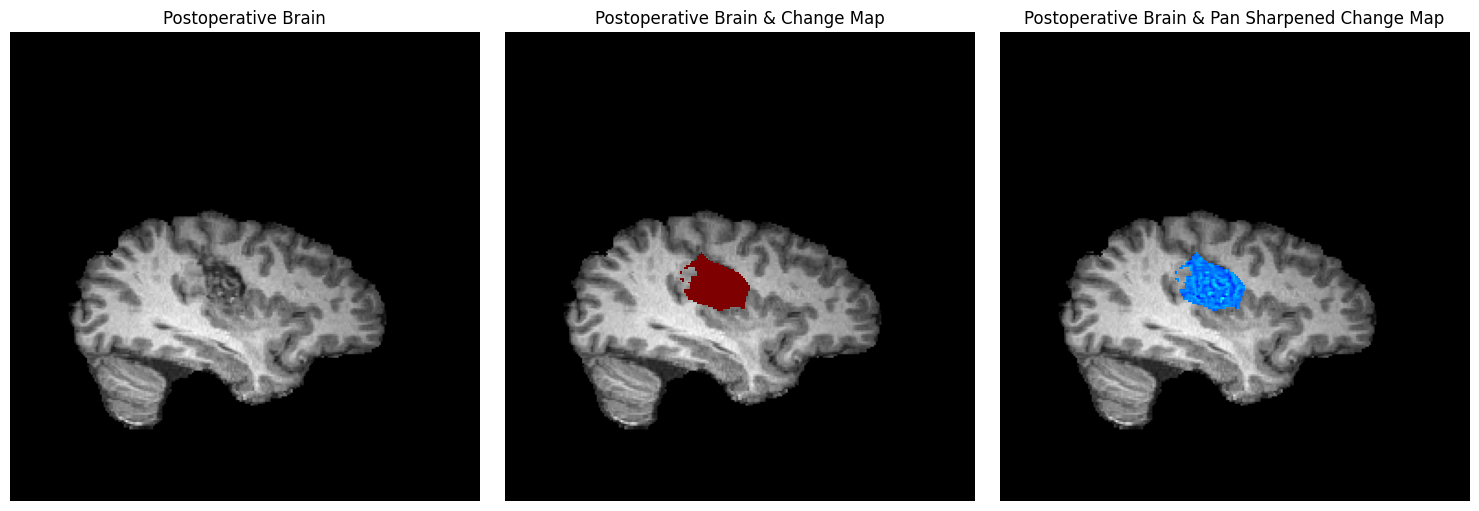

In [5]:
# Load the preoperative MRI scan file
preop_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/2D/ReMIND-039_slice_axial_140_pre_label_0.npz'
preop_data = np.rot90(np.load(preop_file)['data'])

# Load the postoperative MRI scan file
postop_file = '/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/2D/ReMIND-039_slice_axial_140_post_label_0.npz'
postop_data = np.rot90(np.load(postop_file)['data'])
def get_baseline_np(pre: np.ndarray, post: np.ndarray) -> np.ndarray:
    diff = np.abs(pre - post)
    return diff
    # Create a base image which is postop_data but all zeros
base_image = np.zeros_like(postop_data)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(postop_data, cmap='gray')
# axes[0].imshow(masked_change_map_data, cmap='jet', alpha=1, vmin=0.5, vmax=1)
axes[0].set_title('Postoperative Brain')

axes[1].imshow(postop_data, cmap='gray')
axes[1].imshow(masked_change_map_data, cmap='jet', alpha=1, vmin=0.5, vmax=1)
axes[1].set_title('Postoperative Brain & Change Map')

axes[2].imshow(postop_data, cmap='gray')
axes[2].imshow(multiplicative_sharpening_and_filter(masked_change_map_data, postop_data, alpha=5), cmap='jet',
               alpha=1, vmin=0.5, vmax=2.5)
axes[2].set_title('Postoperative Brain & Pan Sharpened Change Map')


for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Presentation

In [6]:
pre_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_label_0.npz")["data"]
post_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_label_0.npz")["data"]


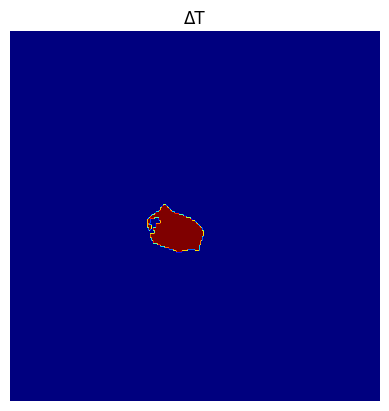

In [7]:
plt.imshow(change_map_data, cmap='jet')
plt.title('ΔT')
plt.axis('off')
plt.show()

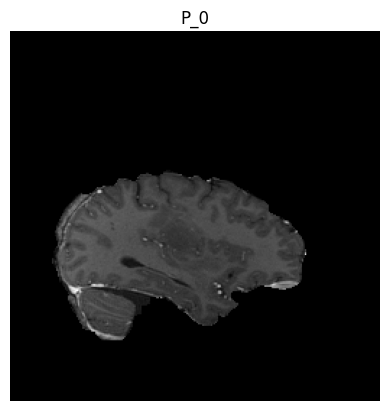

In [8]:
plt.imshow(preop_data, cmap='grey')
plt.title('P_0')
plt.axis('off')
plt.show()

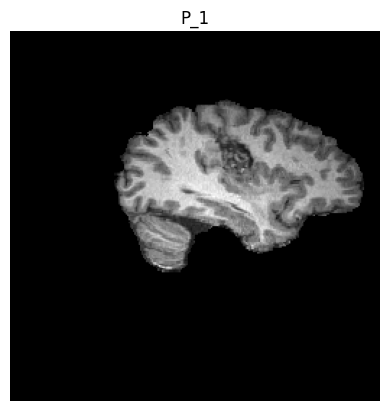

In [49]:
shifted_postop_data = np.roll(postop_data, shift=(-50, 40), axis=(0, 1))
shifted_change_map = np.roll(change_map_data, shift=(-50, 40), axis=(0, 1))
plt.imshow(shifted_postop_data, cmap='grey')
# plt.imshow(shifted_change_map, cmap='jet', alpha=0.5)
plt.title('P_1')
plt.axis('off')
plt.show()